## import

In [1]:
import random, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend
from kaggle_datasets import KaggleDatasets
print('Tensorflow version ' + tf.__version__)

D1104 12:02:25.960031738      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1104 12:02:25.960053093      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1104 12:02:25.960056200      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1104 12:02:25.960058858      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1104 12:02:25.960061222      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1104 12:02:25.960063769      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1104 12:02:25.960066158      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1104 12:02:25.

Tensorflow version 2.12.0


## Distribution Strategy

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [3]:
AUTO = tf.data.experimental.AUTOTUNE # 데이터 로딩에 필요한 CPU의 작업을 동적으로 조정

IMAGE_SIZE = [224, 224]
EPOCHS = 5 # 전체 데이터셋을 몇 번 반복하여 모델을 학습시킬 것인지 정하는 에포크(epoch)의 수
FOLDS = 3 # 교차 검증에서 데이터를 몇 개의 부분집합(fold)으로 나눌 것인지 지정
SEED = 777 # 무작위 작업에서 일관된 결과를 얻기 위해 사용하는 난수 생성기의 시드(seed)값
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

#### Mixed Precision (혼합 정밀도)
- 혼합 정밀도는 float32와 float16과 같이 다른 데이터 타입을 혼합해서 사용하는 기법입니다. float16은 float32보다 메모리를 덜 사용하고, GPU에서는 더 빠른 연산이 가능할 수 있습니다. 그 결과, 더 큰 배치 크기로 훈련하거나 같은 메모리에서 더 빠른 훈련이 가능합니다. Nvidia의 V100 같은 일부 GPU는 이를 위한 특별한 Tensor Cores를 가지고 있어, 혼합 정밀도를 사용할 때 더욱 효율적입니다.

#### XLA (Accelerated Linear Algebra, 가속 선형 대수)
- XLA는 텐서플로우의 그래프 컴파일러로, 모델의 실행 속도를 향상시키는 최적화를 수행합니다. 이것은 모델의 계산 그래프를 더 효율적으로 만들어 GPU나 TPU에서 실행 속도를 높입니다.

In [4]:
# Mixed Precision and/or XLA
MIXED_PRECISION = False
XLA_ACCELERATE = False

# 혼합 정밀도를 활성화
if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

# XLA를 활성화
if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

## Loading the Competition Data

In [5]:
GCS_DS_PATH = '/kaggle/input/tpu-getting-started/'
print(GCS_DS_PATH)

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

/kaggle/input/tpu-getting-started/


In [6]:
TRAINING_FILENAMES[:5]

['/kaggle/input/tpu-getting-started//tfrecords-jpeg-224x224/train/13-224x224-798.tfrec',
 '/kaggle/input/tpu-getting-started//tfrecords-jpeg-224x224/train/11-224x224-798.tfrec',
 '/kaggle/input/tpu-getting-started//tfrecords-jpeg-224x224/train/05-224x224-798.tfrec',
 '/kaggle/input/tpu-getting-started//tfrecords-jpeg-224x224/train/00-224x224-798.tfrec',
 '/kaggle/input/tpu-getting-started//tfrecords-jpeg-224x224/train/02-224x224-798.tfrec']

In [7]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

## Custom LR scheduler

#### Custom Learning Rate Scheduler
- 훈련 중에 학습률(learning rate)을 동적으로 조절하는 함수 또는 규칙을 말합니다. 훈련의 다른 단계에서 적절한 학습률을 적용함으로써 훈련 과정을 더 빠르고 효율적으로 만들 수 있습니다. 이는 훈련 초기에는 학습률을 높여 빠른 진도를 보이다가, 나중에는 세밀한 조정을 위해 학습률을 낮추는 방식으로 진행될 수 있습니다.

rng: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
y: [1e-05, 8.8e-05, 0.000166, 0.000244, 0.000322, 0.0004, 0.000322, 0.0002596000000000001, 0.00020968000000000004, 0.00016974400000000002, 0.00013779520000000003, 0.00011223616000000004, 9.178892800000003e-05, 7.543114240000003e-05, 6.234491392000002e-05, 5.1875931136000024e-05, 4.3500744908800015e-05, 3.6800595927040014e-05, 3.1440476741632015e-05, 2.7152381393305616e-05, 2.3721905114644494e-05, 2.0977524091715595e-05, 1.8782019273372477e-05, 1.702561541869798e-05, 1.5620492334958385e-05]
Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


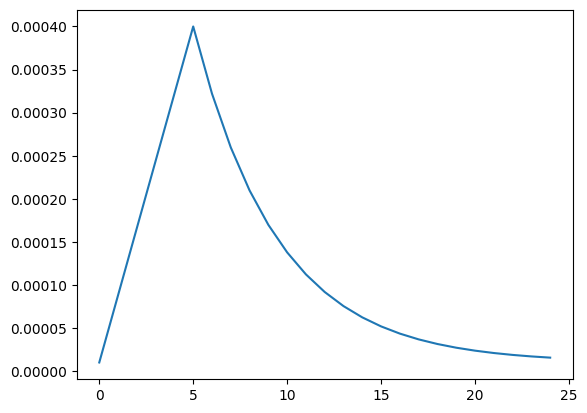

In [8]:
# 학습률 스케줄을 위한 기본값 설정
LR_START = 0.00001                  # 시작 학습률
LR_MAX = 0.00005 * strategy.num_replicas_in_sync  # 최대 학습률, 분산 학습 시 전체 복제본 수에 따라 조정
LR_MIN = 0.00001                    # 최소 학습률
LR_RAMPUP_EPOCHS = 5                # 학습률 증가 기간(에포크 수)
LR_SUSTAIN_EPOCHS = 0               # 최대 학습률을 유지하는 기간(에포크 수)
LR_EXP_DECAY = .8                   # 감소하는 학습률의 비율

# 에포크에 따른 학습률을 계산하는 함수
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:  # 에포크가 증가 구간에 있는 경우
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:  # 에포크가 유지 구간에 있는 경우
        lr = LR_MAX
    else:  # 에포크가 감소 구간에 있는 경우
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

# 학습률 스케줄러를 콜백으로 생성
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# 에포크 범위와 해당하는 학습률 값을 계산
rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]  # 25회 에포크 혹은 설정한 에포크 수만큼의 범위
print('rng:', rng)
y = [lrfn(x) for x in rng]  # 각 에포크에 대한 학습률 계산
print('y:', y)

# 학습률 변화를 시각화
plt.plot(rng, y)

# 학습률 스케줄에 대한 정보 출력
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Dataset Functions

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 10976 training images, 5488 validation images, 7382 unlabeled test images


## Data Augmentation

In [10]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return tensorflow.keras.backend.dot(tensorflow.keras.backend.dot(rotation_matrix, shear_matrix), tensorflow.keras.backend.dot(zoom_matrix, shift_matrix))

In [11]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tensorflow.keras.backend.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = tensorflow.keras.backend.cast(idx2,dtype='int32')
    idx2 = tensorflow.keras.backend.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

## Display Example Augmentation

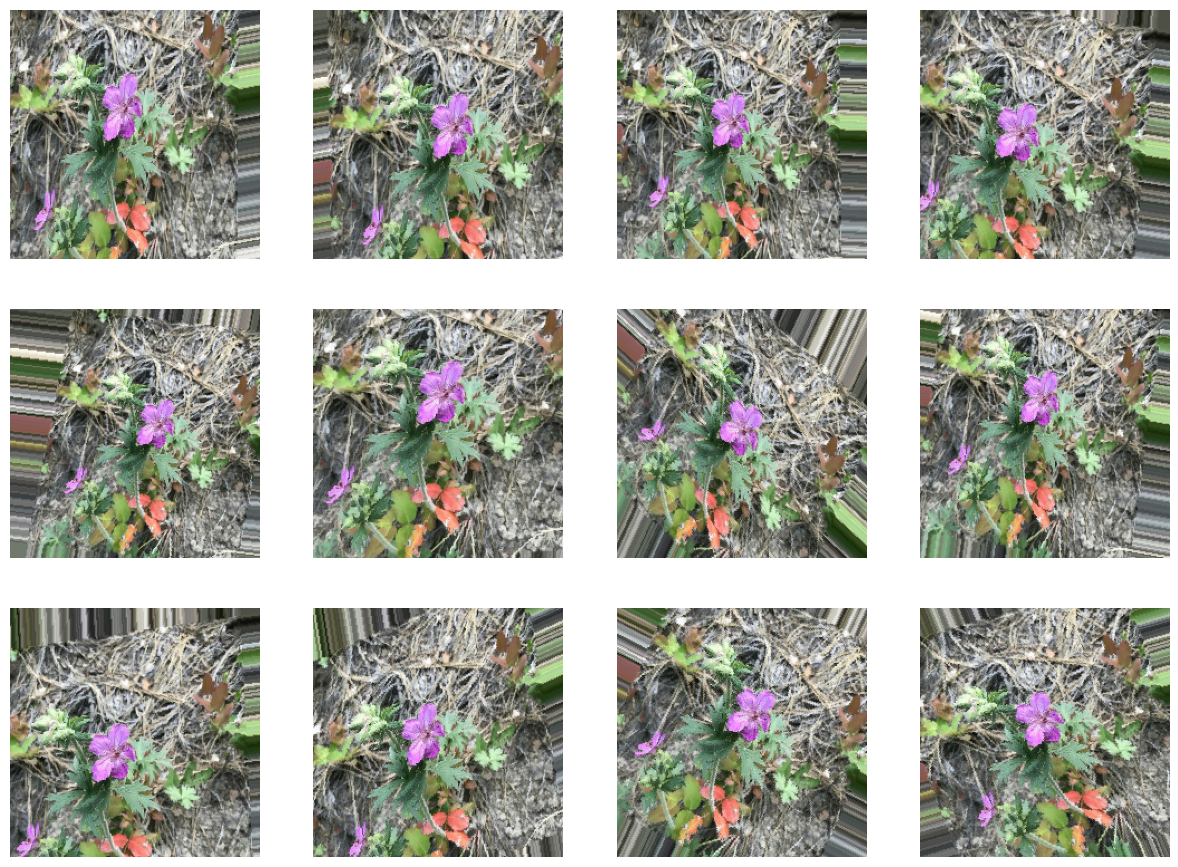

In [12]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## Build, Train, Infer Model

In [13]:
from tensorflow.keras.applications import DenseNet201

def get_model():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def train_cross_validate(folds = 5):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        model = get_model()
        history = model.fit(
            get_training_dataset(train_dataset), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = [lr_callback], # early_stopping
            validation_data = get_validation_dataset(val_dataset),
            verbose=2
        )
        models.append(model)
        histories.append(history)
    return histories, models

def train_and_predict(folds = 5):
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    print('Start training %i folds'%folds)
    histories, models = train_cross_validate(folds = folds)
    print('Computing predictions...')
    # get the mean probability of the folds models
    probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return histories, models
    
# run train and predict
histories, models = train_and_predict(folds = FOLDS)

Start training 3 folds

#########################
### FOLD 1
#########################
74836368/74836368 [==============================] - 0s 0us/step

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/5


2023-11-04 12:05:05.240169: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:05:07.934349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:07:20.754721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:07:21.285617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


85/85 - 226s - loss: 4.4827 - sparse_categorical_accuracy: 0.0616 - val_loss: 3.9819 - val_sparse_categorical_accuracy: 0.1765 - lr: 1.0000e-05 - 226s/epoch - 3s/step

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/5
85/85 - 19s - loss: 2.0757 - sparse_categorical_accuracy: 0.5563 - val_loss: 1.1784 - val_sparse_categorical_accuracy: 0.7313 - lr: 8.8000e-05 - 19s/epoch - 228ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/5
85/85 - 19s - loss: 0.8326 - sparse_categorical_accuracy: 0.8198 - val_loss: 0.6028 - val_sparse_categorical_accuracy: 0.8603 - lr: 1.6600e-04 - 19s/epoch - 225ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/5
85/85 - 19s - loss: 0.4632 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.5474 - val_sparse_categorical_accuracy: 0.8714 - lr: 2.4400e-04 - 19s/epoch - 225ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/5
85/85 - 19s - loss: 0.

2023-11-04 12:10:46.309949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:10:48.958718: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:12:58.158135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:12:58.671678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


85/85 - 222s - loss: 4.4381 - sparse_categorical_accuracy: 0.0735 - val_loss: 3.9247 - val_sparse_categorical_accuracy: 0.1742 - lr: 1.0000e-05 - 222s/epoch - 3s/step

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/5
85/85 - 19s - loss: 2.0416 - sparse_categorical_accuracy: 0.5668 - val_loss: 1.1625 - val_sparse_categorical_accuracy: 0.7164 - lr: 8.8000e-05 - 19s/epoch - 229ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/5
85/85 - 20s - loss: 0.8126 - sparse_categorical_accuracy: 0.8251 - val_loss: 0.6487 - val_sparse_categorical_accuracy: 0.8396 - lr: 1.6600e-04 - 20s/epoch - 230ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/5
85/85 - 19s - loss: 0.4683 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.5623 - val_sparse_categorical_accuracy: 0.8594 - lr: 2.4400e-04 - 19s/epoch - 228ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/5
85/85 - 19s - loss: 0.

2023-11-04 12:16:24.483096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:16:27.012813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:18:36.744185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:18:37.312541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


85/85 - 223s - loss: 4.3293 - sparse_categorical_accuracy: 0.0986 - val_loss: 3.8901 - val_sparse_categorical_accuracy: 0.1806 - lr: 1.0000e-05 - 223s/epoch - 3s/step

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/5
85/85 - 19s - loss: 2.0409 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.1988 - val_sparse_categorical_accuracy: 0.7291 - lr: 8.8000e-05 - 19s/epoch - 219ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/5
85/85 - 19s - loss: 0.8405 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.5832 - val_sparse_categorical_accuracy: 0.8619 - lr: 1.6600e-04 - 19s/epoch - 221ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/5
85/85 - 19s - loss: 0.4988 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.5129 - val_sparse_categorical_accuracy: 0.8763 - lr: 2.4400e-04 - 19s/epoch - 220ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/5
85/85 - 19s - loss: 0.

2023-11-04 12:20:20.198448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:20:20.688486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


58/58 [==============================] - 48s 403ms/step


2023-11-04 12:21:08.199916: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:21:08.678899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


58/58 [==============================] - 50s 443ms/step


2023-11-04 12:21:58.572025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:21:59.072459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


58/58 [==============================] - 47s 393ms/step
Generating submission.csv file...


## Confusion Matrix and Validation Score

In [14]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [15]:
%%time
all_labels = []; all_prob = []; all_pred = []
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)
for j, (trn_ind, val_ind) in enumerate( kfold.split(TRAINING_FILENAMES) ):
    print('Inferring fold',j+1,'validation images...')
    VAL_FILES = list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES'])
    NUM_VALIDATION_IMAGES = count_data_items(VAL_FILES)
    cmdataset = get_validation_dataset(load_dataset(VAL_FILES, labeled = True, ordered = True))
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    all_labels.append( next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() ) # get everything as one batch
    prob = models[j].predict(images_ds)
    all_prob.append( prob )
    all_pred.append( np.argmax(prob, axis=-1) )
cm_correct_labels = np.concatenate(all_labels)
cm_probabilities = np.concatenate(all_prob)
cm_predictions = np.concatenate(all_pred)

Inferring fold 1 validation images...
Cause: could not parse the source code of <function <lambda> at 0x7affe21d04c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d04c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d04c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7affe21d0c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d0c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d0c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
47/47 [==============================] - 24s 500ms/step
Inferring fold 2 validation images...
Cause: could not parse the source code of <function <lambda> at 0x7affddf14280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affddf14280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affddf14280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7affe21d04c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d04c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d04c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
47/47 [==============================] - 22s 470ms/step
Inferring fold 3 validation images...
Cause: could not parse the source code of <function <lambda> at 0x7affe21d0c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d0c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affe21d0c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7affddf14280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affddf14280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7affddf14280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
36/36 [==============================] - 22s 613ms/step
CPU times: user 8min 54s, sys: 42 s, total: 9min 36s
Wall time: 1min 10s


In [16]:
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions); print()

Correct   labels:  (16465,) [57 52 14 ... 67 69 64]
Predicted labels:  (16465,) [57 52 14 ... 67 69 64]



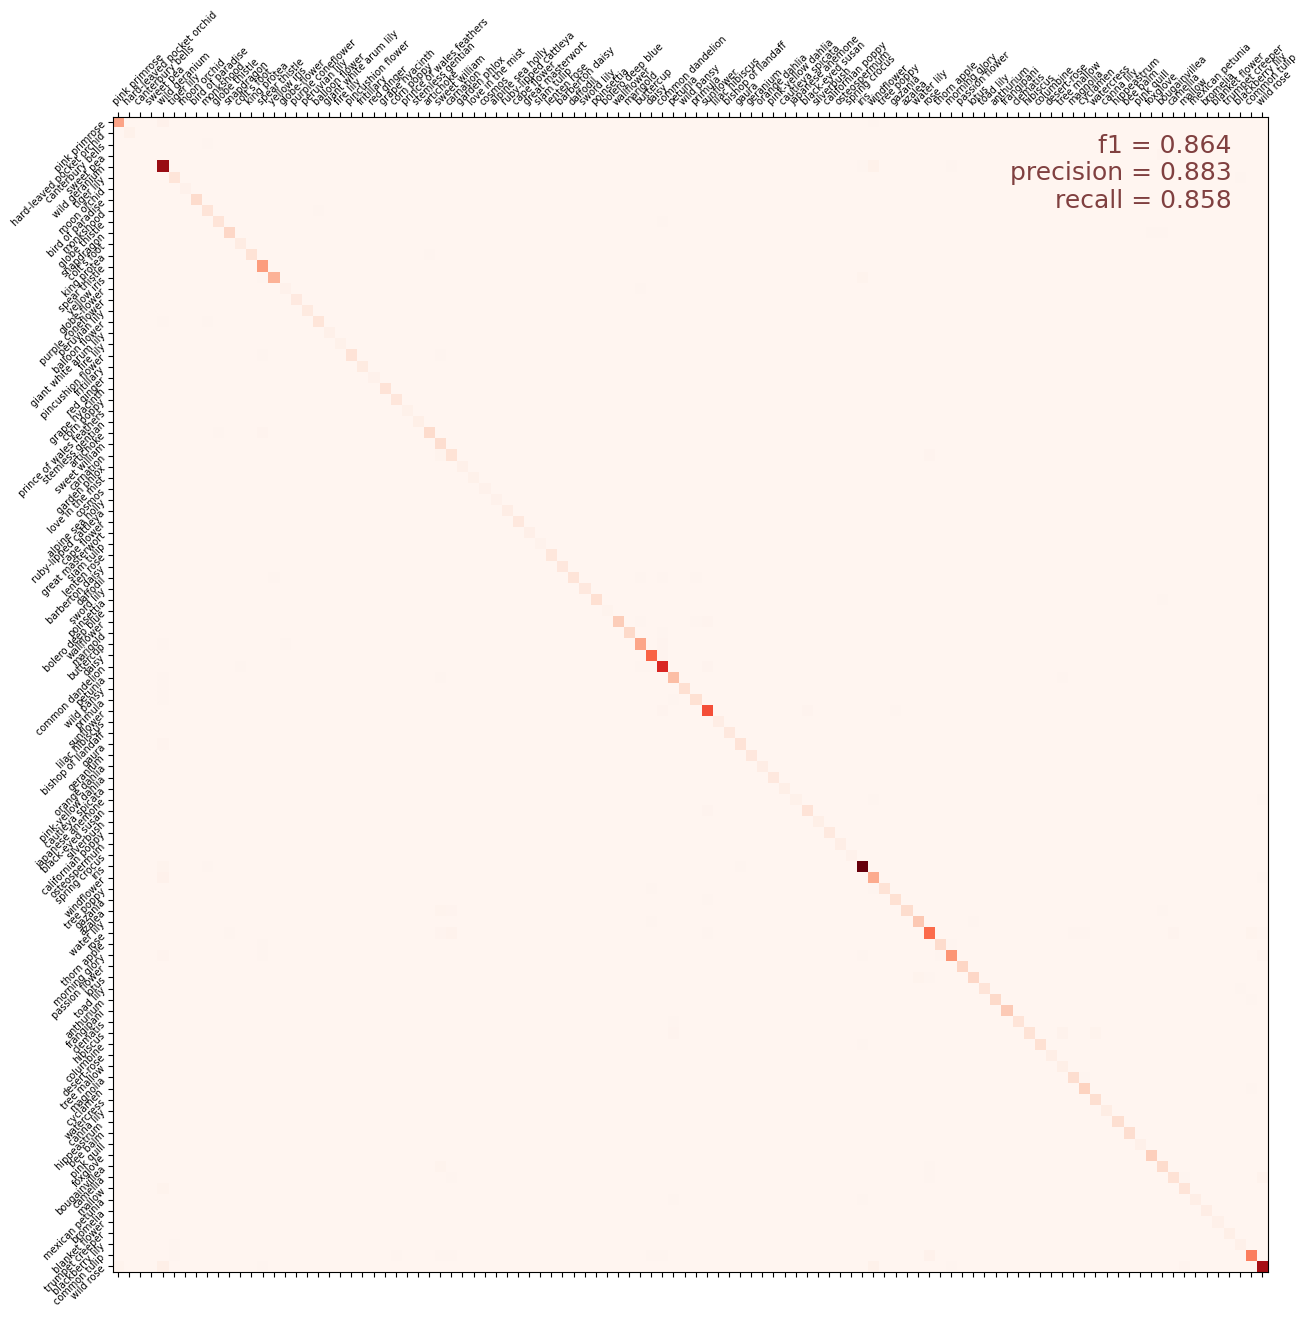

f1 score: 0.864, precision: 0.883, recall: 0.858



In [17]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall));
print()